**<h1><center>CS 464</center></h1>**
**<h1><center>Introduction to Machine Learning</center></h1>**
**<h1><center>Spring 2022</center></h1>**
**<h1><center>Homework 3</center></h1>**
<h4><center>Due: DEC 23, 2022 23:59 (GMT+3)</center></h4>

In this third homework assignment, you are asked to develop a system that can be used to supply additional information to weather forecasts. For this task, you are provided a dataset that consists of weather images that belong to four different weather conditions: [cloudy, rain, shiny, sunrise]. Your model will classify images considering these class labels. 

For this assignment, **using PyTorch is mandatory.**

**Tip:** You may experience latencies in file I/O if you are using Google Colab. In this regard, we recommend you upload your data to Google Drive as a zip file and unzip the folder contents in your drive. If you would like to upload the data files separately, it may take significant time.

You will submit a single ipynb file as the homework submission. If you want to provide further explanation about your work, you can add Markdown cells to do so. [Here](https://www.markdownguide.org/), you can find a guide for Markdown syntax. Upload your homework with the following filename convention: \<BilkentID\>\_\<Name\>\_\<Surname\>.ipynb

**Contact:**
- [Yusuf Dalva](mailto:yusuf.dalva@bilkent.edu.tr)
- [Ahmet Burak Yıldırım](mailto:a.yildirim@bilkent.edu.tr)

**Dataset**<br>
You can find the dataset [here](https://www.kaggle.com/datasets/pratik2901/multiclass-weather-dataset). 


# **Q1** [12 points]
This part consists of 4 questions which you are expected to answer. Please fill in the following cell in Markdown format. Each question is worth 2 points.

a) Do we need to output the actual probability values when performing classification with the softmax layer? If not, how do these numbers represent the likelihood of classes? Also, does the output values should be in a specific range for us to make a classification? <br>

No we don't need to output actual probability values when performing classificiation with softmax layer. The softmax layer's output has probabilities of each class and to classify a sample, the class with the highest probability is selected. The output values of the softmax layer have to be in a specific range because they are probabilities and should be in the range [0,1].

b) From the perspective of model complexity, how you can identify when a model underfits or overfits? Which plots are informative for detecting this behavior? <br>

Overfitting and underfitting can be detected in several ways. First looking at the comparison of training and validation loss curves, if the training loss is significantly higher (or lower) than the validation loss, the model may be overfitting. If both losses are not improving at all in each epoch, the model might be underfitting. We can also compare the accuracies of training,validation and test and if training accuracy is significantly higher than the test accuracy, then  the model might be overfitting.


c) In neural networks, how does the ReLU function help us to generalize to conplex feature spaces? Why we are not using linear layers only? <br>

ReLU function brings non-linearity to the model which can help the model evaluate more complex, i.e. non-linear, data. Linear functions are only capable of evaluating linear data when in fact most of the data we use is non-linear.


d) Assume that you are going to pass the feature matrix with dimensions 64x64x5 (Height x Width x Channel size) through a convolutional layer. If our convolutional layer has a kernel size of 3x3 and the number of filters is 6, how many learnable parameters are present? <br>

There will be 3*3*5*6 = 270 learnable parameters. Each filter is 3x3 and are convolved with 5 input channels and there are 6 filters. 





# **Q2** [88 points]

## Necessary Imports
In the cell below, we import some utilities that you can make use of in this assignment. Note that you need to use PyTorch in this assignment. To report certain metrics (like precision, recall, accuracy) you may use utilities from *scikit-learn* library. You can edit these imports considering your implementation as long as you use PyTorch.

## Setup

In [4]:
import os 
import time
import random

import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models
from torch.utils.data import Dataset, DataLoader

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, f1_score, precision_score, recall_score, accuracy_score

You can test whether hardware acceleration with GPU is enabled in the cell below. In addition, if you have GPU access, you can check the amount of available GPU memory.

In [5]:
# setting device as GPU if available, else CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

# CUDA device information
if device.type == 'cuda':
    print('GPU Name:', torch.cuda.get_device_name(0))
    print('Memory Stats:')
    print('  - Allocated:', round(torch.cuda.memory_allocated(0)/1024**3,1), 'GB')
    print('  - Cached:   ', round(torch.cuda.memory_reserved(0)/1024**3,1), 'GB')
    print('  - Total:    ', round(torch.cuda.get_device_properties(0).total_memory/1024**3,1), 'GB')

Using device: cuda
GPU Name: Tesla T4
Memory Stats:
  - Allocated: 0.0 GB
  - Cached:    0.0 GB
  - Total:     14.8 GB


**DO NOT CHANGE**<br>
To evaluate your implementation fairly, we set seed values for random sampling methods in PyTorch, Numpy, and Python random library. These seeds are set to evaluate your models successfully, so do not change these values.

In [6]:
# for reproducable results
torch.manual_seed(464)
torch.cuda.manual_seed(464)
np.random.seed(464)
random.seed(464)
if device.type == 'cuda':
    torch.backends.cudnn.deterministic=True

## Load Data [6 points]
In this assignment, you will use a custom dataset, which you need a wrapper class to access its data. For this purpose, implement a custom dataset class to organize data with the specifications you need. This class will load batches of data using a PyTorch DataLoader later. The class signature of CustomDataset class is provided to you in the cell below, where you can implement your custom dataset.

**IMPORTANT:** As you may have difficulties while fitting all images to your RAM, you need to read the images while getting that item (each item is an image here). We encourage you to read the data files in the "__getitem__" function to avoid encountering any issues related to fitting the data to memory. This way, you do not need to hold the dataset in a single variable, which would be memory intensive.

In [7]:
class CustomDataset(Dataset):
    def __init__(self, data, labels):
        self.data = torch.tensor(data, dtype= torch.float).to(device)
        self.labels = torch.tensor(labels, dtype= torch.long).to(device)

    '''This function should return sample count in the dataset'''
    def __len__(self):
        return len(self.data)

    '''This function should return a single sample and its ground truth value from the dataset corresponding to index parameter '''
    def __getitem__(self, index):
        image = self.data[index]
        label = self.labels[index]

        return image, label


In [8]:
def read_dataset(path):
    data = []
    labels = []
    for root, dirs, files in os.walk(path):
        for file in files:
            if file.endswith('.jpg') or file.endswith('.jpeg'):
                image = Image.open(os.path.join(root, file), mode='r')
                image = image.convert('RGB')
                image = image.resize((224, 224))
                image = np.array(image)/255
                image = np.moveaxis(image, -1, 0)
                data.append(image)
                if root.split('/')[-1] == 'Cloudy':
                    labels.append(0)
                elif root.split('/')[-1] == 'Rain':
                    labels.append(1)
                elif root.split('/')[-1] == 'Shine':
                    labels.append(2)
                elif root.split('/')[-1] == 'Sunrise':
                    labels.append(3)

   

    
    train_data, test_data, train_labels, test_labels = train_test_split(data, labels, test_size=0.2, random_state=464, shuffle=True)
    train_data, val_data, train_labels, val_labels = train_test_split(train_data, train_labels, test_size=0.125, random_state=464, shuffle=True)
 
    train_dataset = CustomDataset(train_data, train_labels)
    val_dataset = CustomDataset(val_data, val_labels)
    test_dataset = CustomDataset(test_data, test_labels)
    return train_dataset, val_dataset, test_dataset


In [9]:
from google.colab import drive
drive.mount("/content/gdrive")

Mounted at /content/gdrive


In [10]:
torch.cuda.is_available()
os.environ['CUDA_VISIBLE_DEVICES'] ='0'

You can implement an additional function to read and construct custom dataset objects for training, validation, and test sets. While constructing the dataset, consider the following issues:
- Dataset contains images that end with prefixes *.jpg* and *.jpeg*.
- If you use PIL to read images, you should convert them to "RGB" format to operate on three color channels.
- Resize the dataset images to 224x224. You are going to design models that take images with tensor shape 224x224x3.
- If you wish, you can change the ordering of the color channels with np.moveaxis function

Lastly, the train-validation-test split for the dataset provided to you is 70-10-20 in terms of percentages. While constructing the dataset, remember that shuffling is a necessary step (to get randomly distributed classes across batches).

You can design your dataset getter method compatible with the line provided below, where train_dataset, val_dataset, and test_dataset are all instances of CustomDataset.

In [11]:
train_dataset, val_dataset, test_dataset = read_dataset('/content/gdrive/MyDrive/Colab Notebooks/Multi-class Weather Dataset/')

<ipython-input-7-76db075b0079>:3: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:230.)
  self.data = torch.tensor(data, dtype= torch.float).to(device)


In [12]:
print(train_dataset[0])

(tensor([[[0.9412, 0.9490, 0.9569,  ..., 0.7804, 0.7843, 0.7569],
         [0.9216, 0.9373, 0.9569,  ..., 0.7686, 0.7843, 0.7608],
         [0.9020, 0.9294, 0.9608,  ..., 0.7451, 0.7882, 0.7686],
         ...,
         [0.0471, 0.0549, 0.0471,  ..., 0.1765, 0.2471, 0.2824],
         [0.0588, 0.0471, 0.0275,  ..., 0.3490, 0.3490, 0.3765],
         [0.0667, 0.0392, 0.0157,  ..., 0.7176, 0.6667, 0.6667]],

        [[0.9490, 0.9490, 0.9569,  ..., 0.7882, 0.7765, 0.7529],
         [0.9294, 0.9373, 0.9569,  ..., 0.7765, 0.7804, 0.7569],
         [0.9059, 0.9255, 0.9608,  ..., 0.7569, 0.7843, 0.7647],
         ...,
         [0.0863, 0.0941, 0.0863,  ..., 0.0392, 0.1098, 0.1451],
         [0.0980, 0.0863, 0.0667,  ..., 0.2078, 0.2118, 0.2392],
         [0.1059, 0.0784, 0.0549,  ..., 0.5765, 0.5294, 0.5294]],

        [[0.9451, 0.9490, 0.9569,  ..., 0.7686, 0.7686, 0.7451],
         [0.9255, 0.9373, 0.9569,  ..., 0.7569, 0.7725, 0.7490],
         [0.9020, 0.9294, 0.9608,  ..., 0.7373, 0.7765, 0

## Models [16 points]
In this assignment, you will implement one CNN (Convolutional Neural Network) model and one FCN (Fully-Connected Network) model, where the class signatures are provided below.

### Convolutional Neural Network (CNN) Model [8 points]
As the first model, you will implement a convolutional model. Your model will include 3 CONV + POOL blocks, which denotes one Convolutional layer followed by a Max Pooling Layer. The channel sizes for convolutional blocks are [16, 32, 64], respectively. For all convolutional layers, take kernel size as 3, stride as one, and apply padding such that convolutions do not change the shape on width and height dimensions. 
<br><br>
Following the convolutional part, you will perform image classification for the dataset provided to you. You can use ReLU activation as the non-linearity in your model (except the classification layer).

In [13]:
class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        
        self.conv1 = nn.Conv2d(3, 16, 3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(16, 32, 3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(32, 64, 3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(64 * 28 * 28, 4)
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
       
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = x.view(-1, 64 * 28 * 28)
        x = self.fc1(x)
        x = self.softmax(x)
        return x





### Fully Connected Network (FCN) Model [8 points]
The second model you will try is a Fully Connected Network composed of Linear layers and non-linear activation functions connected to each other. For this part, the number of features for your linear layers is [1024, 512, 256]. Again, you can use ReLU as your non-linear activation function in your model (except the classification layer).

In [14]:

class FCNet(nn.Module):
    def __init__(self, num_features):
        super(FCNet, self).__init__()
        self.fc1 = nn.Linear(num_features, 1024)
        self.fc2 = nn.Linear(1024, 512)
        self.fc3 = nn.Linear(512, 256)
        self.fc4 = nn.Linear(256, 4)
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        x = x.view(-1, 3 * 224 * 224)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = self.fc4(x)
        x = self.softmax(x)
        return x


## Training and Evaluation of FCN [22 points]

Now that you implemented the model definition of CNN and FCN, you will train these models with the hyperparameters you chose. The hyperparameters that you may change are listed in the cell below. Using the FCN model defined, train a classifier that predicts weather condition classes specified by the dataset. For the optimizer, use [SGD](https://pytorch.org/docs/stable/generated/torch.optim.SGD.html) optimizer provided by PyTorch. You should try out different hyper-parameters like learning rates, epochs, momentum, and weight decay. For [momentum](https://machinelearningmastery.com/gradient-descent-with-momentum-from-scratch/) and [weight decay](https://paperswithcode.com/method/weight-decay), you can read about these concepts if you are interested.

While training your model, save your best model over different epochs. You must select an appropriate metric to define the best model at a time step. You can implement the training procedure in the cell below. If you want to explain the reasoning behind your metric selection, you can add a markdown cell and provide your comments.

### Training [12 points]

In [15]:
#HINT: note that your training time should not take many days.

#TODO:
#Pick your hyper parameters
max_epoch = 60
train_batch = 50
test_batch = 64
learning_rate = 5e-4
momentum = 0.9
weight_decay = 5e-04




In [16]:

model = FCNet(3 * 224 * 224)
model.to("cuda:0")

def train_fc(model, train_dataset, max_epoch, train_batch, test_batch, learning_rate, momentum, weight_decay):
 
    loss_t = []
    loss_v = []
    accuracy_v = []
    accuracy_t = []
    total = 0
    correct = 0
    
    criterion = nn.CrossEntropyLoss()
  
    optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=momentum, weight_decay=weight_decay)
   
    train_loader = DataLoader(train_dataset, batch_size=train_batch, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=test_batch, shuffle=True)
  
    for epoch in range(max_epoch):
        total_t = 0
        total_v = 0
  
        for i, (images, labels_t) in enumerate(train_loader):
            outputs_t = model(images)
            loss = criterion(outputs_t, labels_t)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()  
            total_t += loss.item()

        _, predicted = torch.max(outputs_t.data, 1)
        total += labels_t.size(0)
        correct += (predicted == labels_t).sum().item()
        accuracy2 = 100 * correct / total
        accuracy_t.append(accuracy2)
         
        total_t = total_t/(len(train_dataset)/train_batch)

        model.eval()
        for images, labels_v in val_loader:
          outputs_v = model(images)
          loss_val = criterion(outputs_v, labels_v)
          """
            
           optimizer.zero_grad()
           loss_val.backward()
           optimizer.step()
          """
            
          total_v += loss_val.item()
        total_v = total_v/(len(val_dataset)/test_batch)

        loss_v.append(total_v)
        loss_t.append(total_t)
      

        _, predicted = torch.max(outputs_v.data, 1)
        total += labels_v.size(0)
        correct += (predicted == labels_v).sum().item()
        accuracy = 100 * correct / total
        accuracy_v.append(accuracy)
        print('Epoch: {}/{}, Train Loss: {}, Train Accuracy: {}, Val Loss: {}, Val Accuracy: {}'.format(epoch+1, max_epoch, total_t, accuracy2, total_v, accuracy))
    return loss_v, loss_t, accuracy_v, accuracy_t   


In [17]:
loss_v, loss_t, accuracy_v, accuracy_t = train_fc(model,train_dataset, max_epoch, train_batch, test_batch, learning_rate, momentum, weight_decay)

Epoch: 1/60, Train Loss: 1.4072583924406215, Train Accuracy: 35.13513513513514, Val Loss: 1.5635172075929895, Val Accuracy: 33.72093023255814
Epoch: 2/60, Train Loss: 1.398933456389392, Train Accuracy: 34.959349593495936, Val Loss: 1.5527212092306761, Val Accuracy: 37.2093023255814
Epoch: 3/60, Train Loss: 1.3878556567195712, Train Accuracy: 39.23444976076555, Val Loss: 1.5369226236258988, Val Accuracy: 42.248062015503876
Epoch: 4/60, Train Loss: 1.3741024188801476, Train Accuracy: 40.33898305084746, Val Loss: 1.517718694906319, Val Accuracy: 40.406976744186046
Epoch: 5/60, Train Loss: 1.353563938237812, Train Accuracy: 42.25721784776903, Val Loss: 1.4902000089662264, Val Accuracy: 43.48837209302326
Epoch: 6/60, Train Loss: 1.3290347032050165, Train Accuracy: 45.610278372591004, Val Loss: 1.4615269888818792, Val Accuracy: 46.12403100775194
Epoch: 7/60, Train Loss: 1.3024675952130988, Train Accuracy: 45.56962025316456, Val Loss: 1.42813596472276, Val Accuracy: 46.01328903654485
Epoch: 8

### Learning Process Analysis [5 points]
Following the training step, you will now provide accuracy and loss plots over all epochs. For this, provide two plots:
- In the first plot, you will provide the value of the accuracy metric over epochs. Your plot should include two curves, one for the training set and the other for the validation set.
- For the second plot, provide the curve for loss values over epochs. Again your plot should include two curves, where one indicates loss on the training set and the second indicates loss for the validation set.

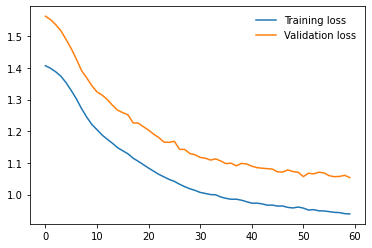

In [18]:
# TODO: Implement your plots here, you can use matplotlib library to do so.
#loss curve
plt.plot(loss_t, label='Training loss')
plt.plot(loss_v, label='Validation loss')
plt.legend(frameon=False)
plt.show()

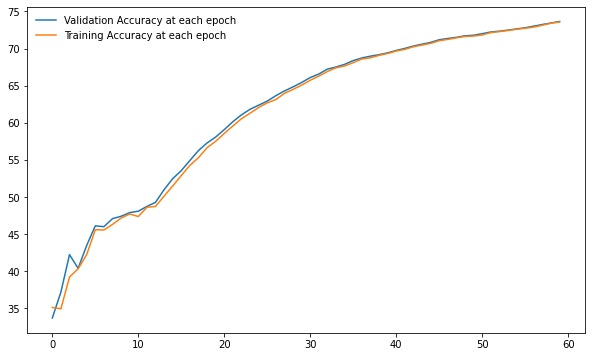

In [19]:
plt.figure(figsize=(10,6))
plt.plot(accuracy_v, label = "Validation Accuracy at each epoch")
plt.plot(accuracy_t, label = "Training Accuracy at each epoch")
plt.legend(frameon=False)
plt.show()

In [22]:
torch.save(model.state_dict(), 'model.pth')
model.load_state_dict(torch.load('model.pth'))

<All keys matched successfully>

### Test [5 points]
As the final step of your analysis, you will test your model using some metrics. For the best model you obtained during training, evaluate your model on the test set. Then, report the confusion matrix. Finally, report accuracy, precision, recall, and $F_1$ score using your model. Report all these metrics using the macro form (macro precision, macro recall, etc.). You can implement these metrics in the cell below. 

In [23]:
# TODO: Implement your evaluation script here, provide the confusion matrix and the requested metrics
def test_fc(test_dataset, test_batch):
    model = FCNet(3 * 224 * 224)
    model.load_state_dict(torch.load('model.pth'))
    model.to("cuda:0")
    model.eval()
    test_loader = DataLoader(test_dataset, batch_size=test_batch, shuffle=True)
    y_true = np.array([])
    y_pred = np.array([])
    with torch.no_grad():
        for images, labels in test_loader:
            outputs = model(images)
            predicted = outputs.argmax(dim = 1, keepdim = True).squeeze()
            y_true = np.append(y_true,labels.cpu())
            y_pred = np.append(y_pred,predicted.cpu())  

    
    print('Test Accuracy: {}%'.format(100*accuracy_score(y_true,y_pred)))
    print('Precision: {}'.format(100*precision_score(y_true, y_pred, average='macro')))
    print('Recall: {}'.format(100*recall_score(y_true, y_pred, average='macro')))
    print('F1 Score: {}'.format(100*f1_score(y_true, y_pred, average='macro')))
    print('Confusion Matrix: {}'.format(confusion_matrix(y_true, y_pred)))

In [24]:
test_fc(test_dataset, test_batch)

Test Accuracy: 80.88888888888889%
Precision: 78.16864721416059
Recall: 78.58880568356375
F1 Score: 78.27474953302767
Confusion Matrix: [[41 10 10  1]
 [ 4 22  4  2]
 [ 9  1 46  0]
 [ 1  0  1 73]]


## Training and evaluation of CNN [22 points]
Similar to the FCN model, you will now train the CNN model that you defined before. Again you are free to try out different hyperparameters. This model also will classify weather images with the four classes provided by the dataset. As the optimizer, again, use the SGD implementation provided by PyTorch. You can implement the training loop in the following cell. 

Similar to the training procedure, you need to save the best model you obtain during training. Select an appropriate criterion (metric) to save the best model. If you wish, you can add a markdown cell to explain your reasoning.

### Training [12 points]

In [40]:
#call the train function for fcn and apply the cnn model to it
max_epoch = 60
train_batch = 64
test_batch = 64
learning_rate = 5e-4
momentum = 0.9
weight_decay = 5e-04
model1 = ConvNet()
model1.to("cuda:0")
tloss_cnn, vloss_cnn, val_acc, train_acc = train_fc(model1, train_dataset, max_epoch, train_batch, test_batch, learning_rate, momentum, weight_decay)
torch.save(model1.state_dict(), 'model1.pth')
model1.load_state_dict(torch.load('model1.pth'))

Epoch: 1/60, Train Loss: 1.464818176502194, Train Accuracy: 31.57894736842105, Val Loss: 1.567206593741358, Val Accuracy: 32.35294117647059
Epoch: 2/60, Train Loss: 1.461774542492257, Train Accuracy: 32.18390804597701, Val Loss: 1.563314522262168, Val Accuracy: 31.61764705882353
Epoch: 3/60, Train Loss: 1.4583480912515139, Train Accuracy: 30.322580645161292, Val Loss: 1.5590453021294248, Val Accuracy: 30.392156862745097
Epoch: 4/60, Train Loss: 1.4531457069716884, Train Accuracy: 30.94170403587444, Val Loss: 1.5538320625777793, Val Accuracy: 31.61764705882353
Epoch: 5/60, Train Loss: 1.4513945331113007, Train Accuracy: 31.61512027491409, Val Loss: 1.5499254074771847, Val Accuracy: 31.470588235294116
Epoch: 6/60, Train Loss: 1.4459075346077868, Train Accuracy: 31.754874651810585, Val Loss: 1.5449062786271086, Val Accuracy: 31.61764705882353
Epoch: 7/60, Train Loss: 1.4413655922100839, Train Accuracy: 31.850117096018735, Val Loss: 1.5375854357153969, Val Accuracy: 32.35294117647059
Epoch

<All keys matched successfully>

### Learning Process Analysis [3 points]
Repeating the same procedure you applied for the FCN model; you will provide two plots about how your training proceeds over epochs. Again, provide two plots: one summarizes the loss values, and the other summarizes the accuracy values. Note that each plot needs to include two curves, one for the validation set and the other for the training set.

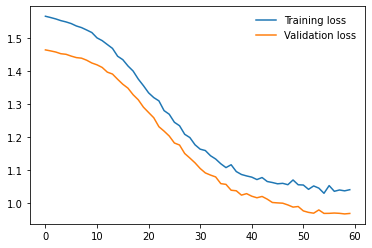

In [41]:
# TODO: Implement your plots here, you can use matplotlib library to do so.
#loss curve
plt.plot(tloss_cnn, label='Training loss')
plt.plot(vloss_cnn, label='Validation loss')
plt.legend(frameon=False)
plt.show()


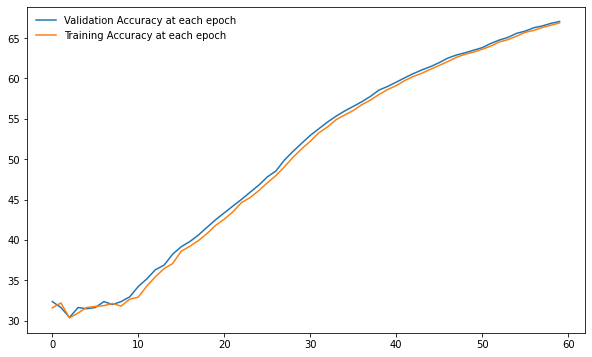

In [42]:
plt.figure(figsize=(10,6))
plt.plot(val_acc, label = "Validation Accuracy at each epoch")
plt.plot(train_acc, label = "Training Accuracy at each epoch")
plt.legend(frameon=False)
plt.show()

### Test [4 points]
Concluding your analysis, report the confusion matrix for the best model you obtained during your CNN model training. Then using this confusion matrix, report accuracy, recall, precision, and $F_1$ score for your best model. Use macro averaging in all of your metrics.

In [48]:
# TODO: Implement your evaluation script here, provide the confusion matrix and the requested metrics
def test_CNN(model, test_dataset, test_batch):
    model.load_state_dict(torch.load('model1.pth'))
    model.to("cuda:0")
    model.eval()
    test_loader = DataLoader(test_dataset, batch_size=test_batch, shuffle=True)
    y_true = np.array([])
    y_pred = np.array([])
    with torch.no_grad():
        for images, labels in test_loader:
            outputs = model(images)
            predicted = outputs.argmax(dim = 1, keepdim = True).squeeze()
            y_true = np.append(y_true,labels.cpu())
            y_pred = np.append(y_pred,predicted.cpu())  

    
    print('Test Accuracy: {}%'.format(100*accuracy_score(y_true,y_pred)))
    print('Precision: {}'.format(100*precision_score(y_true, y_pred, average='macro')))
    print('Recall: {}'.format(100*recall_score(y_true, y_pred, average='macro')))
    print('F1 Score: {}'.format(100*f1_score(y_true, y_pred, average='macro')))
    print('Confusion Matrix: {}'.format(confusion_matrix(y_true, y_pred)))

In [50]:
test_CNN(model1, test_dataset, test_batch)

Test Accuracy: 81.77777777777779%
Precision: 79.15503081128195
Recall: 80.70214093701998
F1 Score: 79.41355415332568
Confusion Matrix: [[36 12 10  4]
 [ 5 25  1  1]
 [ 5  1 50  0]
 [ 1  0  1 73]]


### Discussion [3 points]
Now, try to compare the two models that you trained. How different are these two models regarding the number of parameters used?

Explain your findings by connecting them with your experimental results. You can include your comments on a separate Markdown cell or below the question statement.

The two models gave similar results in terms of performance metrics (accuracy, precision, recall and F1 score) with convolutional neural network producing slightly better outputs. However, the parameters I used are different for the models. For fully connected network, the training batch is 50, whereas for the CNN, it is 64. Applying this slight difference to the models caused them to perform better because when I tried to train the CNN with a training batch size of 64, the training and validation accuracies turned out to be about 5-10% lower than they are now. 

## Transfer Learning [22 points]

As the last part of this assignment, you will practice transfer learning. In this methodology, we aim to use models trained on large-scale datasets for our task. As we do not have access to large datasets and computational resources all the time, we sometimes try to use already trained models (on other datasets) as a good starting point for our model, and then fine-tune the weights considering our task.  

Torchvision library provides numerous models pretrained for specific tasks. [Here](https://pytorch.org/vision/stable/models.html), you can find a list of pretrained models. For this part, you will include [ResNet](https://arxiv.org/abs/1512.03385)-18 model, pretrained with ImageNet dataset. ImageNet is a large dataset where training from scratch would take a long time. You will fine-tune this pretrained module for your task. 
<br>
**Hint:** You can add a Linear layer to adapt the model to the number of classes needed for your task. You can access the number of inputs to the ResNet-18 model as $\texttt{model.fc.in_features}$ and then modify the fully connected layer of the model $\texttt{model.fc}$.
<br>

Using the ResNet-18 backbone, implement this model's training loop (by adapting it to your task). You can implement the training procedure in the cell provided below. Again save your model based on a criterion indicating the best model. Explain the reasoning for your criteria. Use the SGD optimizer provided by PyTorch to optimize your model.

Just like the previous parts, you can also tune your hyperparameters to optimize your model's performance. 

###Training [12 points]

In [51]:
def resnet(model, train_dataset, max_epoch, train_batch, test_batch, learning_rate, momentum, weight_decay):
    for param in model.parameters():
        param.requires_grad = False
    
    model.fc = nn.Linear(512, 4)
    model.to("cuda:0")
    
    loss_t = []
    loss_v = []
    accuracy_v = []
    accuracy_t = []
    total = 0
    correct = 0
    
    criterion = nn.CrossEntropyLoss()
  
    optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=momentum, weight_decay=weight_decay)
   
    train_loader = DataLoader(train_dataset, batch_size=train_batch, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=test_batch, shuffle=True)
  
    for epoch in range(max_epoch):
        total_t = 0
        total_v = 0
  
        for i, (images, labels_t) in enumerate(train_loader):
            outputs_t = model(images)
            loss = criterion(outputs_t, labels_t)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()  
            total_t += loss.item()

        _, predicted = torch.max(outputs_t.data, 1)
        total += labels_t.size(0)
        correct += (predicted == labels_t).sum().item()
        accuracy2 = 100 * correct / total
        accuracy_t.append(accuracy2)
         
        total_t = total_t/(len(train_dataset)/train_batch)

        model.eval()
        for images, labels_v in val_loader:
          outputs_v = model(images)
          loss_val = criterion(outputs_v, labels_v)
          """
            
           optimizer.zero_grad()
           loss_val.backward()
           optimizer.step()
          """
            
          total_v += loss_val.item()
        total_v = total_v/(len(val_dataset)/test_batch)

        loss_v.append(total_v)
        loss_t.append(total_t)
      

        _, predicted = torch.max(outputs_v.data, 1)
        total += labels_v.size(0)
        correct += (predicted == labels_v).sum().item()
        accuracy = 100 * correct / total
        accuracy_v.append(accuracy)
        print('Epoch: {}/{}, Train Loss: {}, Train Accuracy: {}, Val Loss: {}, Val Accuracy: {}'.format(epoch+1, max_epoch, total_t, accuracy2, total_v, accuracy))
    return loss_v, loss_t, accuracy_v, accuracy_t  

In [52]:
max_epoch = 60
train_batch = 64
test_batch = 64
learning_rate = 5e-4
weight_decay = 5e-04

model2 = models.resnet18(pretrained=True)
loss_v, loss_t, accuracy_v, accuracy_t  = resnet(model2, train_dataset, max_epoch, train_batch, test_batch, learning_rate, momentum, weight_decay)
torch.save(model2.state_dict(), 'model2.pth')
model2.load_state_dict(torch.load('model2.pth'))

/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

Epoch: 1/60, Train Loss: 1.4315435077516976, Train Accuracy: 52.63157894736842, Val Loss: 1.414178898904176, Val Accuracy: 48.529411764705884
Epoch: 2/60, Train Loss: 1.235494465809765, Train Accuracy: 48.275862068965516, Val Loss: 1.1474741032693239, Val Accuracy: 54.411764705882355
Epoch: 3/60, Train Loss: 0.9796999067333177, Train Accuracy: 57.41935483870968, Val Loss: 0.9215080801364595, Val Accuracy: 64.70588235294117
Epoch: 4/60, Train Loss: 0.7995043782448678, Train Accuracy: 66.3677130044843, Val Loss: 0.7742387214593128, Val Accuracy: 69.8529411764706
Epoch: 5/60, Train Loss: 0.6778809524400413, Train Accuracy: 70.79037800687286, Val Loss: 0.6700843540968093, Val Accuracy: 72.3529411764706
Epoch: 6/60, Train Loss: 0.584346158077332, Train Accuracy: 73.53760445682451, Val Loss: 0.5996534296896605, Val Accuracy: 75.0
Epoch: 7/60, Train Loss: 0.5310336358968306, Train Accuracy: 75.17564402810305, Val Loss: 0.5416985570856955, Val Accuracy: 75.63025210084034
Epoch: 8/60, Train Los

<All keys matched successfully>

###Learning Process Analysis [3 points]
After training your model, provide two plots summarizing the learning procedure. Like previous parts, you will provide plots for loss value and accuracy progression over epochs. Remember that for each plot, you need to include two curves (one for the training set and one for the validation set).

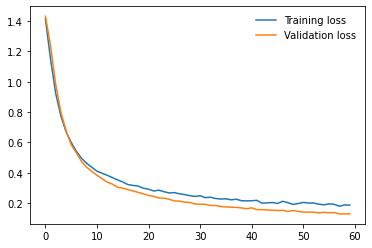

In [53]:
# TODO: Implement your plots here, you can use matplotlib library to do so.
plt.plot(loss_v, label='Training loss')
plt.plot(loss_t, label='Validation loss')
plt.legend(frameon=False)
plt.show()


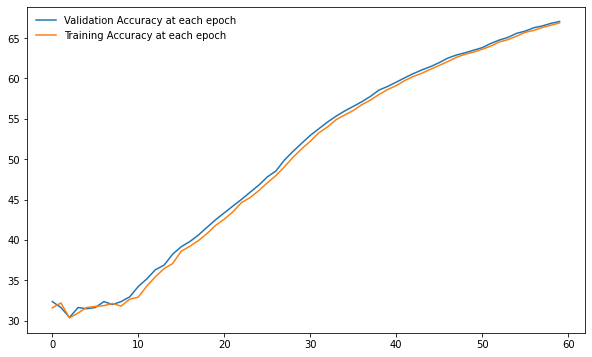

In [54]:
plt.figure(figsize=(10,6))
plt.plot(val_acc, label = "Validation Accuracy at each epoch")
plt.plot(train_acc, label = "Training Accuracy at each epoch")
plt.legend(frameon=False)
plt.show()

### Test [4 points]
Following your analysis, report the confusion matrix for the best model you obtained (with the criteria you defined). Then, report the accuracy, precision, recall and $F_1$ score for the best model. In all of the metrics, use macro averaging.

In [55]:
# TODO: Implement your evaluation script here, provide the confusion matrix and the requested metrics
def test_resnet(model, test_dataset, test_batch):
    #model2 = models.resnet18(pretrained=True)
    #model2.fc = nn.Linear(512, 4)
    model.load_state_dict(torch.load('model2.pth'))
    model.to("cuda:0")
    model.eval()
    test_loader = DataLoader(test_dataset, batch_size=test_batch, shuffle=True)
    y_true = np.array([])
    y_pred = np.array([])
    with torch.no_grad():
        for images, labels in test_loader:
            outputs = model(images)
            predicted = outputs.argmax(dim = 1, keepdim = True).squeeze()
            y_true = np.append(y_true,labels.cpu())
            y_pred = np.append(y_pred,predicted.cpu())  

    
    print('Test Accuracy: {}%'.format(100*accuracy_score(y_true,y_pred)))
    print('Precision: {}'.format(100*precision_score(y_true, y_pred, average='macro')))
    print('Recall: {}'.format(100*recall_score(y_true, y_pred, average='macro')))
    print('F1 Score: {}'.format(100*f1_score(y_true, y_pred, average='macro')))
    print('Confusion Matrix: {}'.format(confusion_matrix(y_true, y_pred)))



In [56]:
test_resnet(model2, test_dataset, test_batch)

Test Accuracy: 90.22222222222223%
Precision: 90.85754985754986
Recall: 90.37235983102919
F1 Score: 90.59005124359454
Confusion Matrix: [[55  0  7  0]
 [ 0 31  1  0]
 [10  0 44  2]
 [ 0  0  2 73]]


### Discussion [3 points]
Now discuss the effectiveness of Transfer Learning. How does it improve performance?  

Transfer learning has significantly improved the performance in various ways. Looking at the training/validation loss curves, it can be seen that they are smoother and closer to each other. The model neither overfits nor underfits. Also, the performance metrics indicate that this model has the highest accuracy, precision, recall and F1 score for all the datasets (training, validation and test) among the three models trained in this homework. These improvements are due to the fact that resnet-18 is a pre-trained model with already optimized weights and biases and also allows more complex datasets to be examined due to its more layered structure (compared to the other two models I trained).

# References
[1] Ajayi, Gbeminiyi (2018), “Multi-class Weather Dataset for Image Classification”, Mendeley Data, V1, doi: 10.17632/4drtyfjtfy.1